In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scglue
import anndata as ad

import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns
import os
from itertools import cycle

%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(4,4),dpi=120)

In [29]:
# Count the number of remaining features in after GLUE preprocessing 
# ATAC peaks calculated based on HVG overlap --> variable peak numbers
# centroid expression sampled --> 2 896 ATAC peaks
# metacell members sampled --> 15 596 ATAC peaks

dset = 'metacells_5_cells_per_spot_10'
dtype = 'synthetic_spatial_rna'
test_path = '/lustre/scratch/kiviaho/spatac/integrations/multiome_5k/'+dset+'/preprocessed_'+dtype+'_20221121.h5ad'
dat = sc.read_h5ad(test_path)
dat[:,dat.var['highly_variable']]

In [2]:
path = '/lustre/scratch/kiviaho/spatac/integrations/multiome_5k/single_cell_all/results'
os.chdir(path)

In [3]:
# DOWNLOAD DATA
rna = sc.read_h5ad('rna-20221121-with-glue-embeddings.h5ad')
atac = sc.read_h5ad('atac-20221121-with-glue-embeddings.h5ad')
glue = scglue.models.load_model('glue-model-20221121.dill')

# Add common column key to plot with
rna.obs['SEACell_id'] = rna.obs['ATAC_SEACell_id']
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

[INFO] autodevice: Using CPU as computation device.


In [4]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)
combined = ad.concat([rna, atac])
combined.obs['SEACell_id'] = combined.obs['SEACell_id'].astype('category')

/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/merge.py:555: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  dfs = [df.reindex(index=new_index) for df in dfs]
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


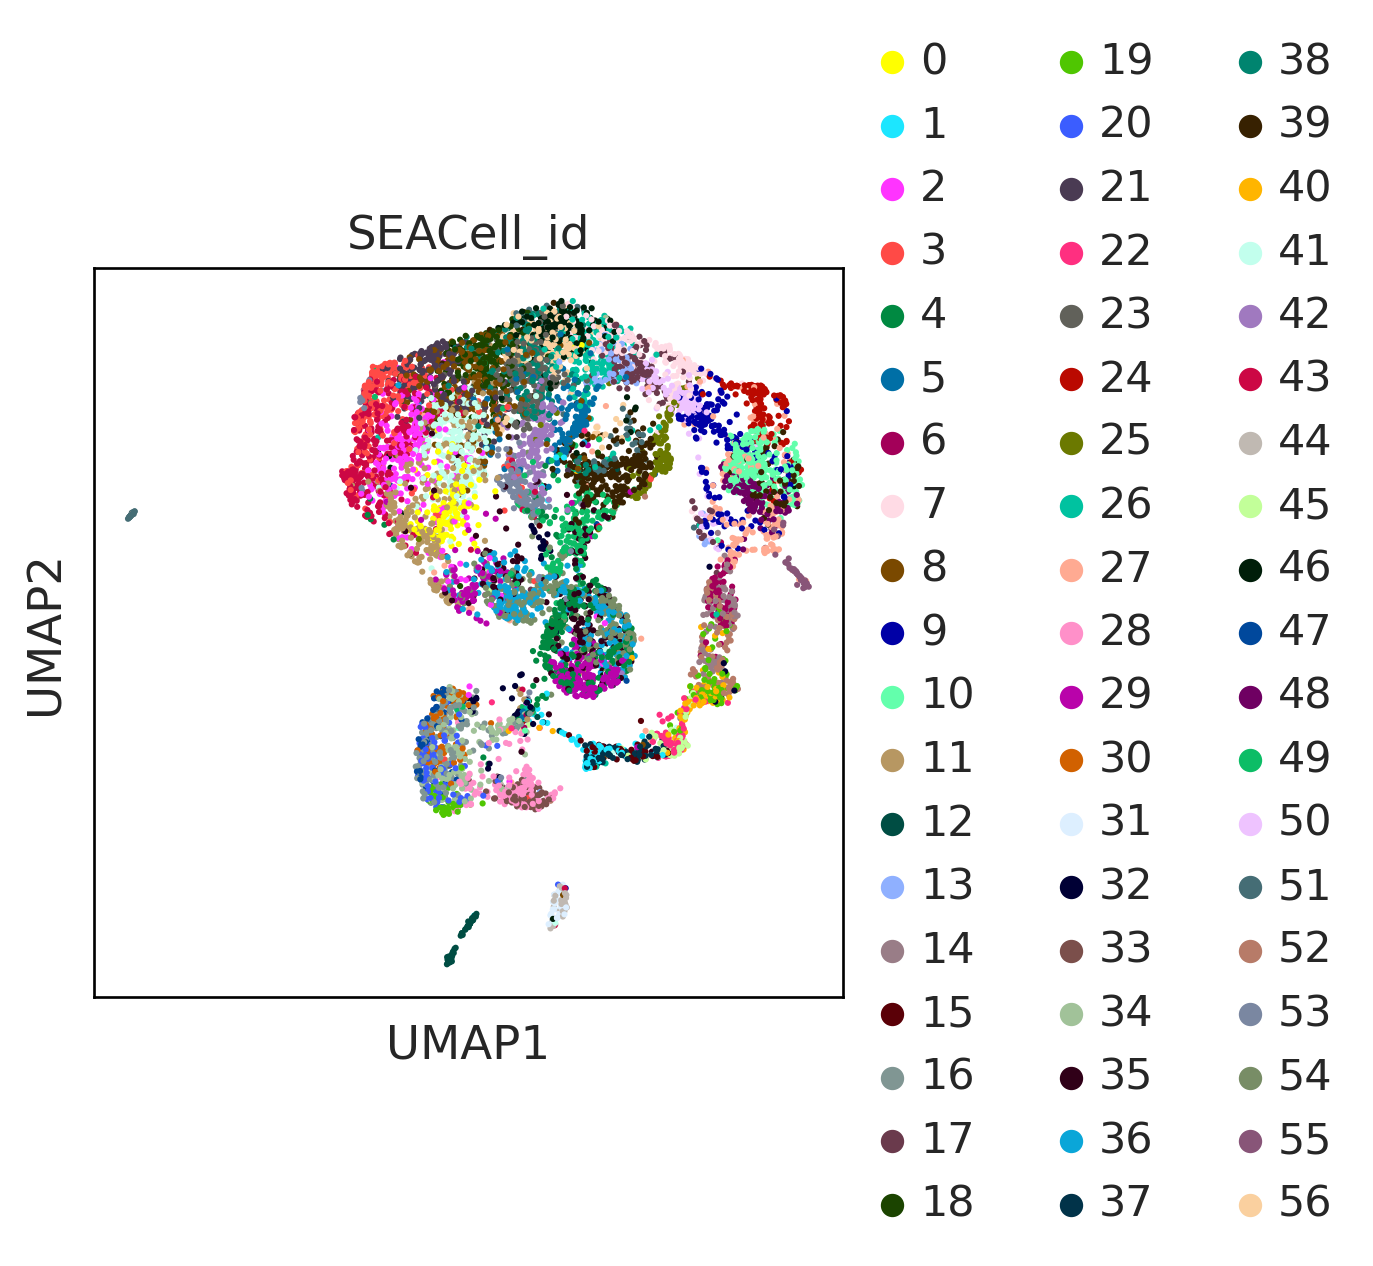

In [6]:
sc.pl.umap(combined, color=["SEACell_id"])

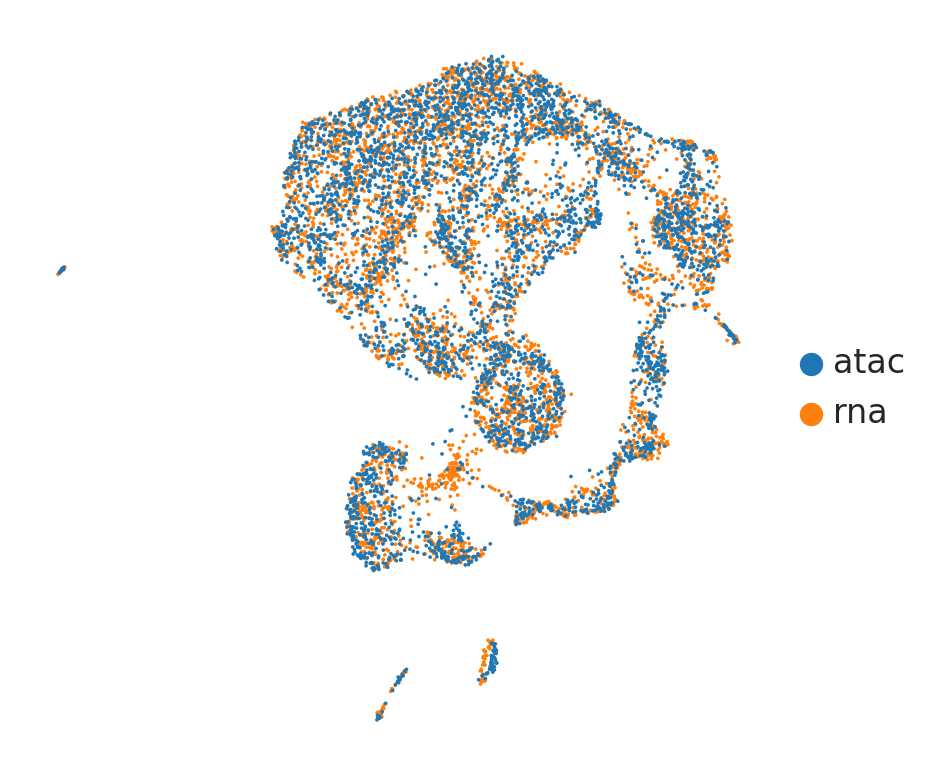

In [7]:
path = '/lustre/scratch/kiviaho/spatac/'
os.chdir(path)
sc.set_figure_params(figsize=(4,4),dpi=120,dpi_save=800)
sc.pl.umap(combined, color=["domain"],s=5,legend_fontsize=10, frameon=False,title='',
save='shared-umap-space-domain-color.png')

In [8]:
data_umap = combined.obsm['X_umap']
metadata = pd.DataFrame({'umap_x': data_umap[:,0],
                         'umap_y':data_umap[:,1],
                         'Label': combined.obs['SEACell_id'],
                         'domain': combined.obs['domain']})

metadata = metadata.sort_values(['Label'])
metadata['Label'] = metadata['Label'].astype(str)

/tmp/ipykernel_15554/1321515251.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('/lustre/scratch/kiviaho/spatac/plots/combined_umap_plot_domain_multiome5k.png',figsize=(3,3),dpi=600)


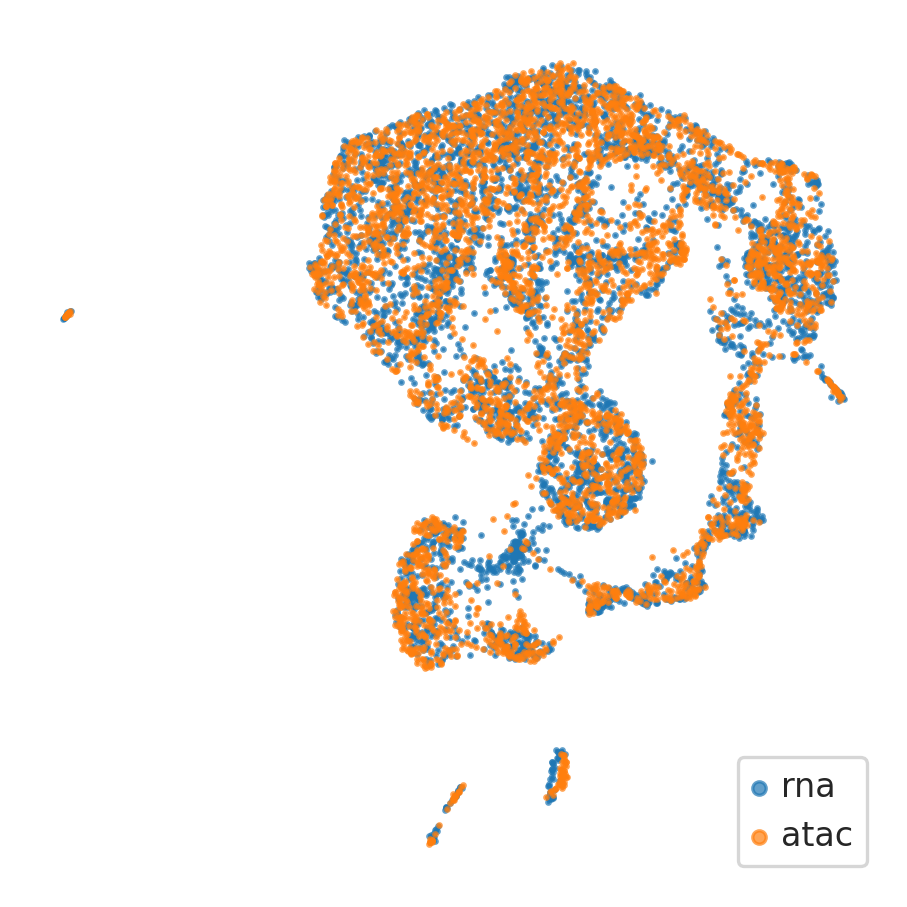

In [9]:
# Save a UMAP plot with good formatting
domains = np.array(['rna','atac'])
mark_sz = 1

colors = cycle(cm.get_cmap('tab10').colors)
fig, ax1 = plt.subplots(1, 1)

for dom,col in zip(domains,colors):
    metadata_interest = metadata[metadata['domain']==dom]
    scatter = ax1.scatter(metadata_interest['umap_x'],
                metadata_interest['umap_y'],
                s = mark_sz,
                color = col,
                cmap='tab10',
                alpha=0.7);
    

ax1.legend(domains,
          loc='lower right',
          fontsize=10,
          markerscale=4.0)
    

ax1.set_title('')
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])
ax1.set_xlabel('UMAP1',fontsize=10)
ax1.set_ylabel('UMAP2',fontsize=10)

ax1.axis('off')

plt.tight_layout()
plt.savefig('/lustre/scratch/kiviaho/spatac/plots/combined_umap_plot_domain_multiome5k.png',figsize=(3,3),dpi=600)

/tmp/ipykernel_15554/2267493921.py:53: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('/lustre/scratch/kiviaho/spatac/plots/combined_umap_plot_multiome5k.png',figsize=(3,3),dpi=600)


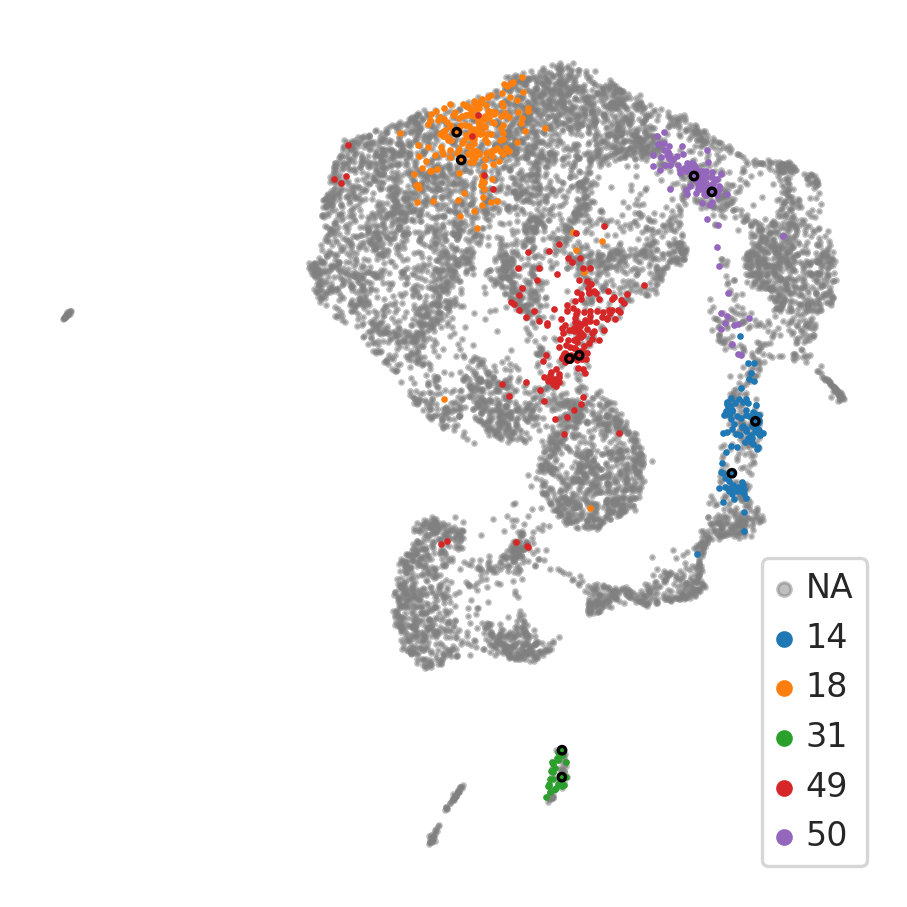

In [10]:
# Save a UMAP plot with good formatting
to_keep = np.array(['14','18','31','49','50'])
mark_sz = 1
metacells = np.unique(atac.obs[atac.obs.SEACell_id.isin(to_keep.astype(int))].SEACell)
metadata_metacells = metadata.loc[metacells]

colors = cycle(cm.get_cmap('tab10').colors)
fig, ax1 = plt.subplots(1, 1)
#fig.set_size_inches(4,4)
#fig.set_dpi(800)
metadata_rest = metadata[~metadata['Label'].isin(to_keep)]
ax1.scatter(metadata_rest['umap_x'],
            metadata_rest['umap_y'],
            color=(0.5, 0.5, 0.5),
            s = mark_sz,
            alpha=0.5)

for lab,col in zip(to_keep,colors):
    metadata_interest = metadata[metadata['Label']==lab]
    scatter = ax1.scatter(metadata_interest['umap_x'],
                metadata_interest['umap_y'],
                s = mark_sz,
                color = col,
                cmap='tab10');
    
metacells = np.unique(atac.obs[atac.obs.SEACell_id.isin(to_keep.astype(int))].SEACell)
metadata_metacells = metadata.loc[metacells]

ax1.scatter(metadata_metacells['umap_x'],
            metadata_metacells['umap_y'],
            facecolors='none',
            edgecolors='k',
            linewidth=1,
            s=5,
            alpha=1,
            marker='o')

ax1.legend(np.concatenate([['NA'],to_keep]),
          loc='lower right',
          fontsize=10,
          markerscale=4)
    

ax1.set_title('')
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])
ax1.set_xlabel('UMAP1',fontsize=10)
ax1.set_ylabel('UMAP2',fontsize=10)

ax1.axis('off')

plt.tight_layout()
plt.savefig('/lustre/scratch/kiviaho/spatac/plots/combined_umap_plot_multiome5k.png',figsize=(3,3),dpi=600)

## Sampled centroids, no variance in expression

In [11]:
def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for i,ct in enumerate(range(n_cell_types)):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax[i]
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

In [12]:
path = '/lustre/scratch/kiviaho/spatac/integrations/multiome_5k/metacells_5_cells_per_spot_10/results/'
os.chdir(path)

# DOWNLOAD DATA
rna = sc.read_h5ad('rna-20221121-with-glue-embeddings.h5ad')
atac = sc.read_h5ad('atac-20221121-with-glue-embeddings.h5ad')
glue = scglue.models.load_model('glue-model-20221121.dill')

# Add common column key to plot with
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [13]:
import time
n_neighbors = 3

start = time.time()
rna_glue = rna.obsm['X_glue']
atac_glue = atac.obsm['X_glue']

inferred_counts = np.empty((0,6),dtype=float)

for a_idx in range(len(rna_glue)):
    distances = []
    a = rna_glue[a_idx]
    # Calculate the euclidean distance in GLUE space between each 'spot'
    for b_idx in range(len(atac_glue)):
        b = atac_glue[b_idx]
        distances.append(np.linalg.norm(a-b))

    # Extract indices of n nearest matches
    nearest_matches = np.array(distances).argsort()[:n_neighbors]

    # Extract the cell counts and calculate their mean
    inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])
time.time() - start

/tmp/ipykernel_15554/2262186944.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])


277.1278374195099

In [43]:
inferred_spot_cell_counts = pd.DataFrame(inferred_counts, 
                             columns=rna.obs.columns[:inferred_counts.shape[1]],
                             index=rna.obs.index)
inferred_spot_cell_counts.drop(columns=['balancing_weight'],inplace=True)
cell_count_df = rna.obs.iloc[:,0:5]

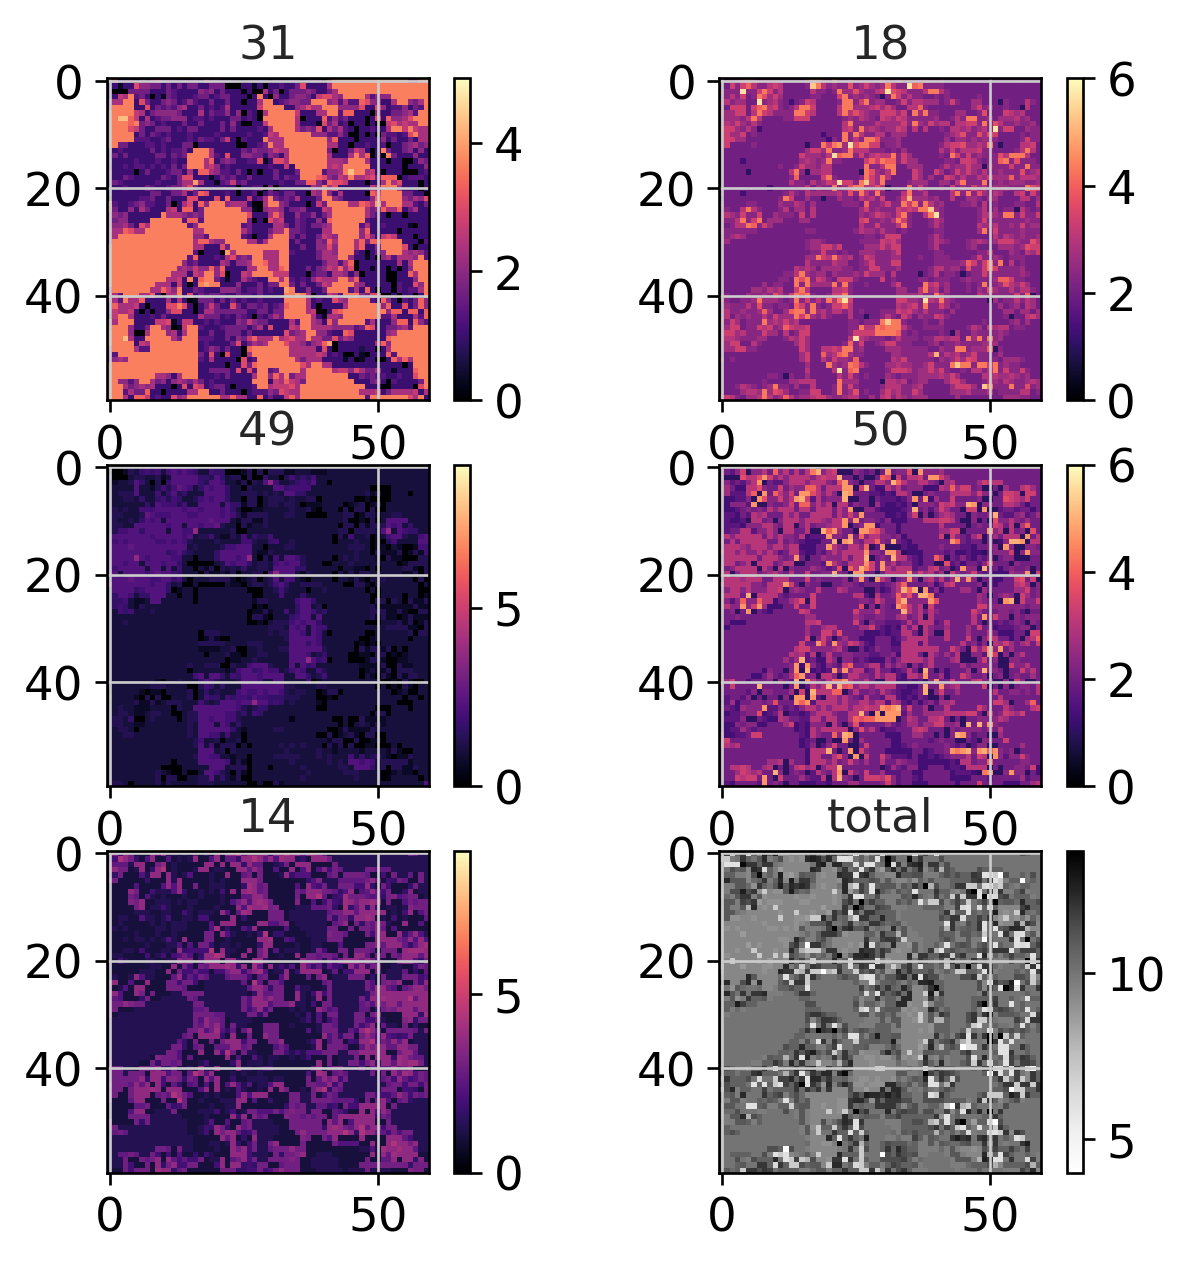

In [65]:
n_locations = [60, 60]
plt.figure(figsize=(6,6),dpi=120)
plot_spatial(inferred_spot_cell_counts.values, 
             n=n_locations, nrows=3, 
             names=inferred_spot_cell_counts.columns, vmax=[5,6,9,6,9,13])

In [ ]:
sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [16, 16]
mpl.rcParams['figure.dpi'] = 100

n_locations = [60, 60]
plot_spatial(cell_count_df.values, # cell_count_df
             n=n_locations, nrows=6, 
             names=cell_count_df.columns, vmax=[5,6,9,6,9,13])

## Integration done by sampling metacells

In [66]:
path = '/lustre/scratch/kiviaho/spatac/integrations/multiome_5k/individual_cells_per_spot_10_from_5_metacells/results/'
os.chdir(path)

# DOWNLOAD DATA
rna = sc.read_h5ad('rna-20221121-with-glue-embeddings.h5ad')
atac = sc.read_h5ad('atac-20221121-with-glue-embeddings.h5ad')
glue = scglue.models.load_model('glue-model-20221121.dill')

# Add common column key to plot with
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)


combined = ad.concat([rna, atac])

sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)


In [67]:
import time
n_neighbors = 3

start = time.time()
rna_glue = rna.obsm['X_glue']
atac_glue = atac.obsm['X_glue']

inferred_counts = np.empty((0,6),dtype=float)

for a_idx in range(len(rna_glue)):
    distances = []
    a = rna_glue[a_idx]
    # Calculate the euclidean distance in GLUE space between each 'spot'
    for b_idx in range(len(atac_glue)):
        b = atac_glue[b_idx]
        distances.append(np.linalg.norm(a-b))

    # Extract indices of n nearest matches
    nearest_matches = np.array(distances).argsort()[:n_neighbors]

    # Extract the cell counts and calculate their mean
    inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])
time.time() - start

/tmp/ipykernel_15554/2262186944.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])


397.2518141269684

In [71]:
inferred_metacell_counts = pd.DataFrame(inferred_counts, 
                             columns=rna.obs.columns[:inferred_counts.shape[1]],
                             index=rna.obs.index)
inferred_metacell_counts.drop(columns=['balancing_weight'],inplace=True)
cell_count_df = rna.obs.iloc[:,0:5]

In [72]:
cell_type = '31'
np.abs(inferred_metacell_counts[cell_type]-cell_count_df[cell_type]).mean()

0.5063888888888863

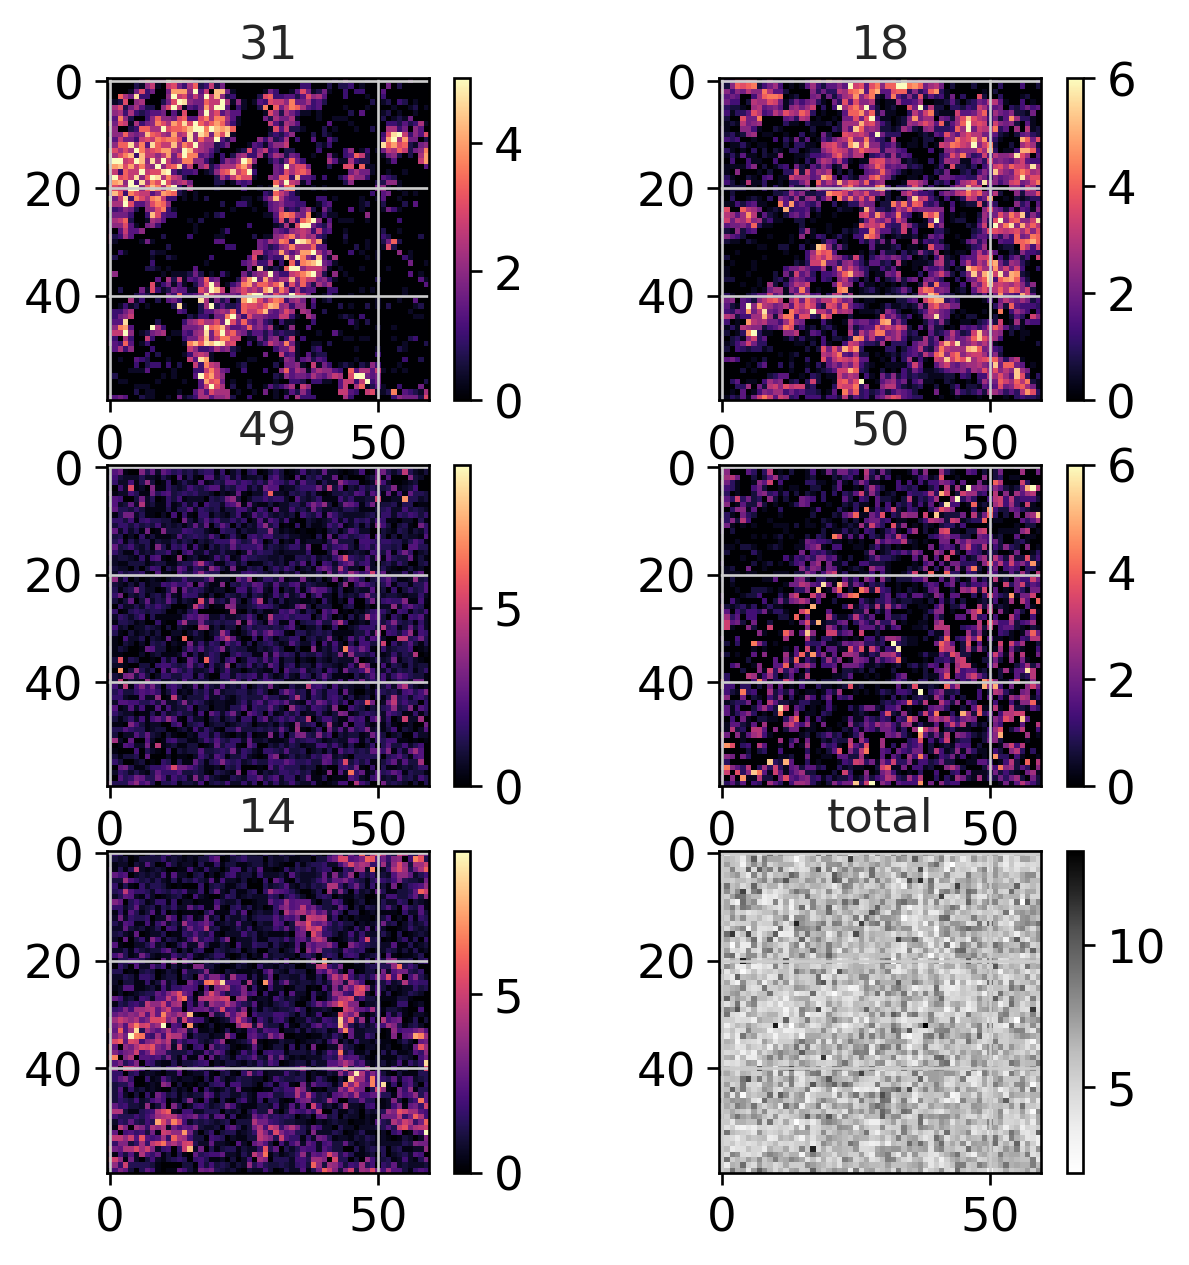

In [73]:
n_locations = [60, 60]
plt.figure(figsize=(6,6),dpi=120)
plot_spatial(inferred_metacell_counts.values, 
             n=n_locations, nrows=3, 
             names=inferred_metacell_counts.columns, vmax=[5,6,9,6,9,13])

## Generating tissue heatmap plots for press

In [74]:
def plot_spatial_alt(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for i,ct in enumerate(range(n_cell_types)):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax[i]
                  )
        plt.axis('off')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.axis('off')
    plt.tight_layout()


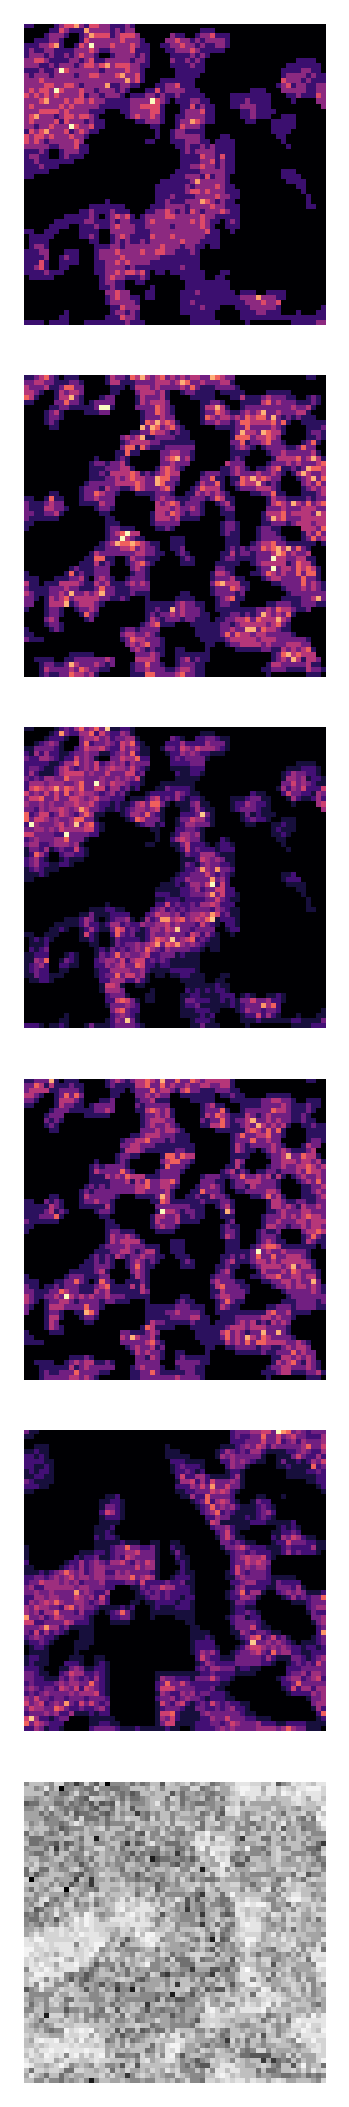

In [82]:
n_locations = [60, 60]
plt.figure(figsize=(12,9),dpi=120)
plot_spatial_alt(cell_count_df.values, 
             n=n_locations, nrows=6, 
             names=cell_count_df.columns, vmax=[5,6,9,6,9,13])
plt.savefig('../../../../plots/multiome5k_metacell_distribution_ground_truth.png',dpi=300)

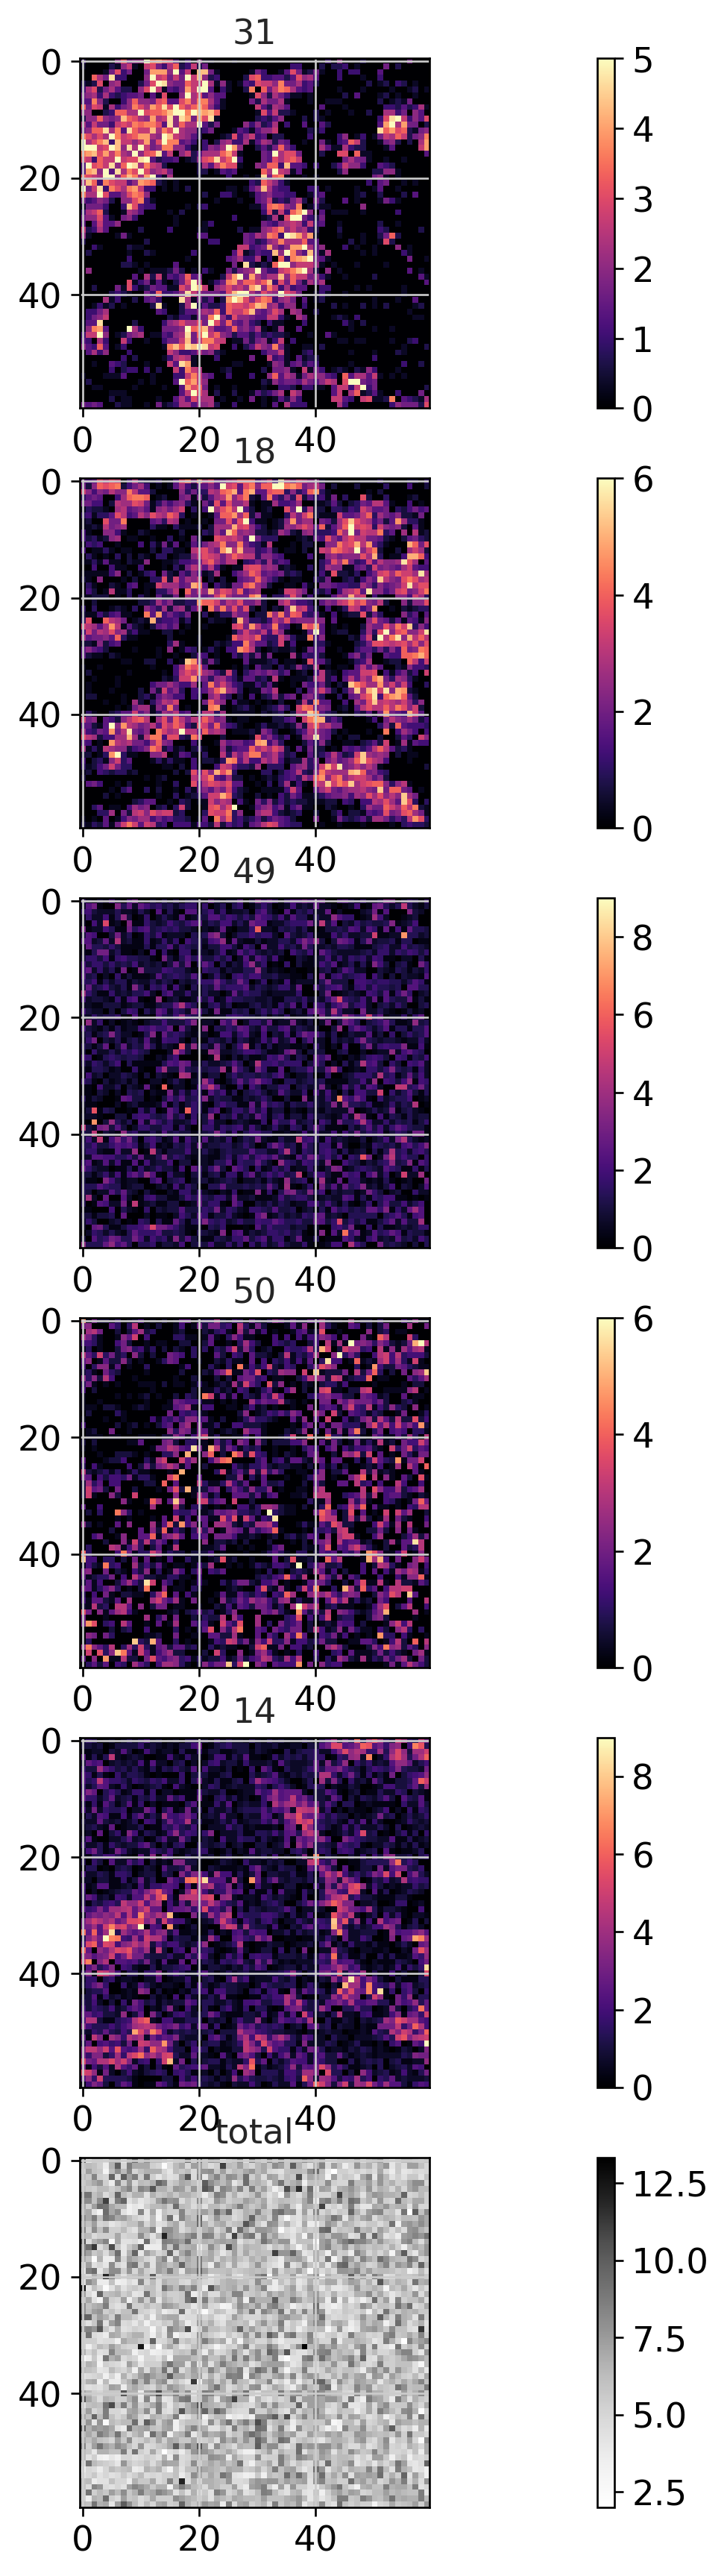

In [87]:
n_locations = [60, 60]
plt.figure(figsize=(24,18),dpi=120)
plot_spatial(inferred_metacell_counts.values, 
             n=n_locations, nrows=6, 
             names=inferred_metacell_counts.columns, vmax=[5,6,9,6,9,13])
plt.savefig('../../../../plots/multiome5k_metacell_distribution_with_scalebars.png',dpi=120)

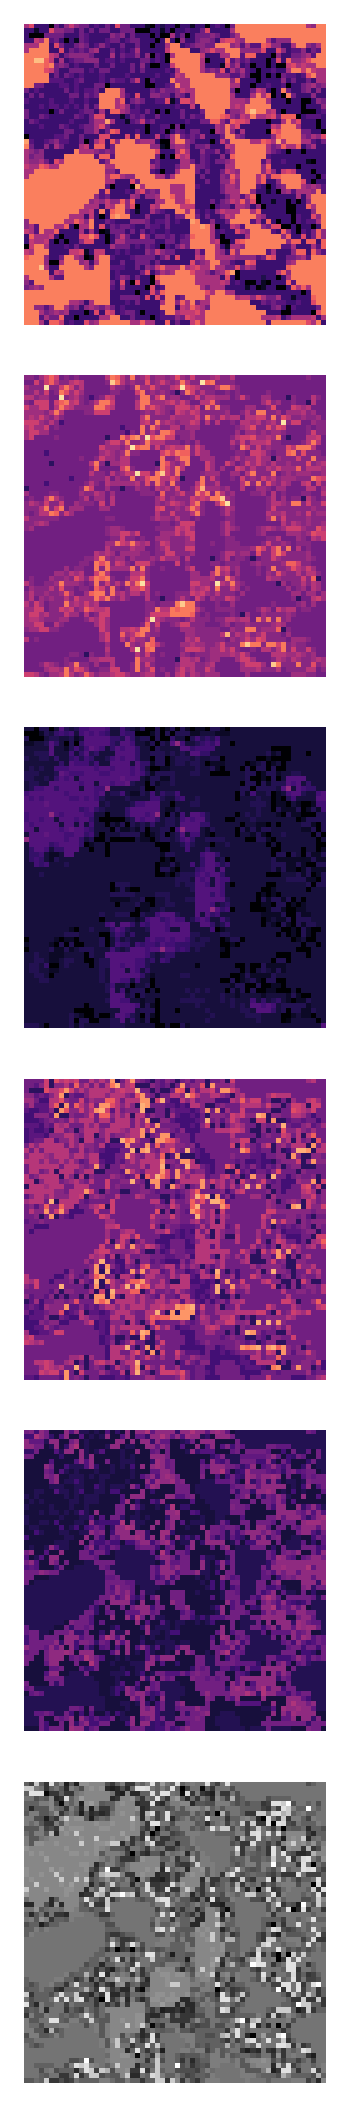

In [84]:
n_locations = [60, 60]
plt.figure(figsize=(12,9),dpi=120)
plot_spatial_alt(inferred_spot_cell_counts.values, 
             n=n_locations, nrows=6, 
             names=inferred_spot_cell_counts.columns, vmax=[5,6,9,6,9,13])
plt.savefig('../../../../plots/multiome5k_metacell_distribution_from_centroids.png',dpi=300)

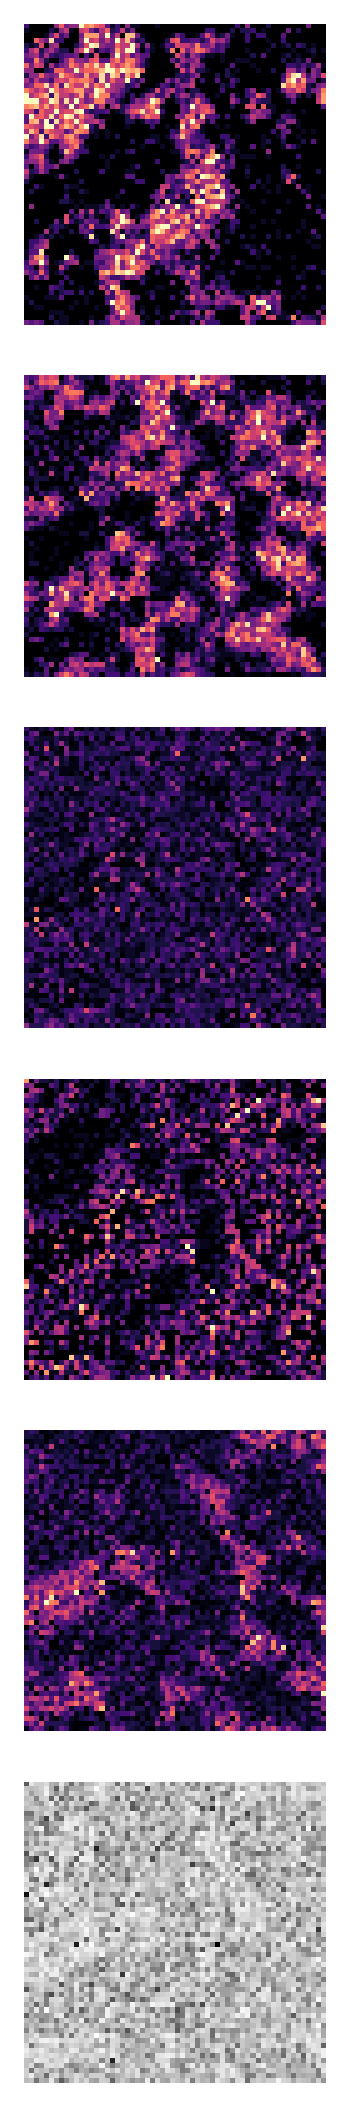

In [85]:
n_locations = [60, 60]
plt.figure(figsize=(12,9),dpi=120)
plot_spatial_alt(inferred_metacell_counts.values, 
             n=n_locations, nrows=6, 
             names=inferred_metacell_counts.columns, vmax=[5,6,9,6,9,13])
plt.savefig('../../../../plots/multiome5k_metacell_distribution_from_metacells.png',dpi=300)